# Test-Time Adaptation for Robust Image Classification

**Deep Learning Project 2024 - University of Trento**

by *Federico Brancasi, Gianmaria Lucca and Jacopo Manenti*

## 1. Introduction and Preliminary Steps

Deep neural networks have revolutionized the field of computer vision, achieving unprecedented performance in tasks such as image classification, object detection, and anomaly detection. However, these models face a significant challenge, called **domain shift**: this phenomenon occurs when a model encounters test data that differs substantially from the training data's distribution, leading to severe performance degradation.

Domain shift can arise in various ways:
- Changes in image style or quality
- Variations in lighting conditions or backgrounds
- Differences in object appearances or contexts

These shifts are common in real-world applications, where deployment environments often differ from controlled training scenarios.

To address this challenge, we explore the concept of **Test-Time Adaptation** (TTA). TTA is an innovative approach aimed to enhance the robustness of pre-trained neural networks for image classification when faced with out-of-distribution test data. The key aspects of TTA are:

1. **On-the-fly Adaptation**: TTA adjusts the model's behavior for each test sample individually
2. **No Retraining Required**: Unlike traditional fine-tuning methods, TTA doesn't require access to the original training data or extensive retraining
3. **Preservation of General Knowledge**: The adaptation process maintains the model's broad understanding while specializing for the current input

Recent advancements in Vision-Language Models (VLMs) have demonstrated remarkable zero-shot transfer capabilities. These models can:
- Perform a wide range of downstream tasks without task-specific training
- Utilize natural language prompts to guide their behavior

In the context of TTA, we explore two promising approaches:

1. **Prompt Engineering**: Designing effective prompts that guide the VLM to perform well on new, unseen data distributions
2. **Prompt Learning**: Automatically learning optimal prompts for specific test-time scenarios, potentially outperforming hand-crafted prompts

By combining the power of VLMs with Test-Time Adaptation techniques, we aim to develop more robust and flexible image classification systems capable of maintaining high performance across diverse and challenging real-world scenarios.

### 1.1 Library Imports and Environment Setup

We start by importing the required libraries and setting up our environment.

In [ ]:
# Standard libraries for data manipulation and visualization
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import json
import csv
from io import BytesIO

# PyTorch and related libraries for deep learning
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# Image processing libraries
from PIL import Image, ImageOps, ImageEnhance
import skimage

# AWS SDK for accessing S3 bucket
import boto3

# Configure matplotlib for inline display in Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = "retina"

print("Libraries imported successfully.")

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Libraries imported successfully.


### 1.2 Reproducibility and CUDA Setup

To ensure our experiments are reproducible and to set up CUDA for GPU acceleration, we use the following code:

In [ ]:
# Fix all the seeds for reproducibility
def set_seeds(seed=0):
    """
    Set seeds for reproducibility.

    Args:
        seed (int): Seed value to use. Default is 0.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    print(f"Random seeds set to {seed} for reproducibility.")

set_seeds(0)

Random seeds set to 0 for reproducibility.


In [ ]:
# CUDA setup
if torch.cuda.is_available():
    device = "cuda"
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = "cpu"
    print("CUDA is not available. Using CPU.")

print(f"Using {device} device")

CUDA is available. Using GPU: Tesla T4
Using cuda device


## 2. Dataset Preparation and Exploration

In this section, we'll prepare our dataset for the TPT implementation focusing on the ImageNet-A dataset, which is commonly used to evaluate robustness to natural distribution shifts.

### 2.1 Custom Dataset for S3

First, we implement a custom Dataset class to load images from an Amazon S3 bucket. This is crucial for efficiently handling large datasets stored in cloud storage.

In [ ]:
class S3ImageFolder(Dataset):
    """
    Custom Dataset for loading images from an Amazon S3 bucket.

    This class enables efficient loading of images stored in S3, which is essential
    for working with large-scale datasets in cloud environments.
    """

    def __init__(self, root, transform=None):
        """
        Initialize the dataset.

        Args:
            root (str): Root directory in the S3 bucket to search for images.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"  # Specify the correct region
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform
        self.instances = []

        # Use paginator for efficient handling of large datasets
        paginator = self.s3_client.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=self.s3_bucket, Prefix=root)

        # Collect valid image files
        for page in pages:
            for item in page.get("Contents", []):
                key = item["Key"]
                path = Path(key)
                if path.suffix.lower() in {".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"}:
                    label = path.parent.name
                    self.instances.append((label, key))

        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        print(f"Dataset initialized with {len(self.instances)} images and {len(self.classes)} classes.")

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.instances)

    def __getitem__(self, idx):
        """
        Retrieve an image and its label.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: (image, label) where image is a PIL Image or torch.Tensor and label is an integer.
        """
        label, key = self.instances[idx]
        try:
            # Download image from S3
            img_bytes = BytesIO()
            self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)
            img = Image.open(img_bytes).convert("RGB")

            # Apply transformations if specified
            if self.transform:
                img = self.transform(img)

            return img, self.class_to_idx[label]
        except Exception as e:
            print(f"Error loading image at index {idx}: {str(e)}")
            # Return a placeholder image and label if loading fails
            return torch.zeros((3, 224, 224)), -1

### 2.2 ImageNet-A Class Definitions

Then, we define the classes for ImageNet-A.

In [ ]:
# Dictionary to map class indexes to ImageNet-A class names
imageneta_classes = {
    0: "stingray", 1: "goldfinch", 2: "junco", 3: "american robin", 4: "jay", 5: "bald eagle", 6: "vulture", 7: "newt", 8: "american bullfrog", 9: "box turtle", 10: "green iguana",
    11: "agama", 12: "chameleon", 13: "american alligator", 14: "garter snake", 15: "harvestman", 16: "scorpion", 17: "tarantula", 18: "centipede", 19: "sulphur-crested cockatoo",
    20: "lorikeet", 21: "hummingbird", 22: "toucan", 23: "duck", 24: "goose", 25: "koala", 26: "jellyfish", 27: "sea anemone", 28: "flatworm", 29: "snail", 30: "crayfish",
    31: "hermit crab", 32: "flamingo", 33: "great egret", 34: "oystercatcher", 35: "pelican", 36: "sea lion", 37: "chihuahua", 38: "golden retriever", 39: "rottweiler",
    40: "german shepherd dog", 41: "pug", 42: "red fox", 43: "Persian cat", 44: "lynx", 45: "lion", 46: "american black bear", 47: "mongoose", 48: "ladybug", 49: "rhinoceros beetle",
    50: "weevil", 51: "fly", 52: "bee", 53: "ant", 54: "grasshopper", 55: "stick insect", 56: "cockroach", 57: "mantis", 58: "leafhopper", 59: "dragonfly", 60: "monarch butterfly",
    61: "small white", 62: "gossamer-winged butterfly", 63: "starfish", 64: "cottontail rabbit", 65: "porcupine", 66: "fox squirrel", 67: "marmot", 68: "bison", 69: "skunk", 70: "armadillo",
    71: "baboon", 72: "white-headed capuchin", 73: "african bush elephant", 74: "pufferfish", 75: "academic gown", 76: "accordion", 77: "acoustic guitar", 78: "airliner", 79: "ambulance",
    80: "apron", 81: "balance beam", 82: "balloon", 83: "banjo", 84: "barn", 85: "wheelbarrow", 86: "basketball", 87: "lighthouse", 88: "beaker", 89: "bikini", 90: "bow", 91: "bow tie",
    92: "breastplate", 93: "broom", 94: "candle", 95: "canoe", 96: "castle", 97: "cello", 98: "chain", 99: "chest", 100: "christmas stocking", 101: "cowboy boot", 102: "cradle", 103: "rotary dial telephone",
    104: "digital clock", 105: "doormat", 106: "drumstick", 107: "dumbbell", 108: "envelope", 109: "feather boa", 110: "flagpole", 111: "forklift", 112: "fountain", 113: "garbage truck",
    114: "goblet", 115: "go-kart", 116: "golf cart", 117: "grand piano", 118: "hair dryer", 119: "clothes iron", 120: "jack-o'-lantern", 121: "jeep", 122: "kimono", 123: "lighter",
    124: "limousine", 125: "manhole cover", 126: "maraca", 127: "marimba", 128: "mask", 129: "mitten", 130: "mosque", 131: "nail", 132: "obelisk", 133: "ocarina", 134: "organ", 135: "parachute",
    136: "parking meter", 137: "piggy bank", 138: "billiard table", 139: "hockey puck", 140: "quill", 141: "racket", 142: "reel", 143: "revolver", 144: "rocking chair", 145: "rugby ball",
    146: "salt shaker", 147: "sandal", 148: "saxophone", 149: "school bus", 150: "schooner", 151: "sewing machine", 152: "shovel", 153: "sleeping bag", 154: "snowmobile", 155: "snowplow",
    156: "soap dispenser", 157: "spatula", 158: "spider web", 159: "steam locomotive", 160: "stethoscope", 161: "couch", 162: "submarine", 163: "sundial", 164: "suspension bridge", 165: "syringe",
    166: "tank", 167: "teddy bear", 168: "toaster", 169: "torch", 170: "tricycle", 171: "umbrella", 172: "unicycle", 173: "viaduct", 174: "volleyball", 175: "washing machine", 176: "water tower",
    177: "wine bottle", 178: "shipwreck", 179: "guacamole", 180: "pretzel", 181: "cheeseburger", 182: "hot dog", 183: "broccoli", 184: "cucumber", 185: "bell pepper", 186: "mushroom",
    187: "lemon", 188: "banana", 189: "custard apple", 190: "pomegranate", 191: "carbonara", 192: "bubble", 193: "cliff", 194: "volcano", 195: "baseball player", 196: "rapeseed",
    197: "yellow lady's slipper", 198: "corn", 199: "acorn"
}

# Note: The full dictionary contains 200 classes (0-199)

### 2.3 Data Loading Function

Now, let's create a function to load our data using the custom S3ImageFolder class.

In [ ]:
def get_data(batch_size, img_root, preprocess):
    """
    Create and return a DataLoader for the S3ImageFolder dataset.

    Args:
        batch_size (int): The batch size for the DataLoader.
        img_root (str): The root directory in the S3 bucket to search for images.
        preprocess (callable): A function/transform to apply to the image after loading.

    Returns:
        DataLoader: A DataLoader instance for the dataset.
    """
    dataset = S3ImageFolder(root=img_root, transform=preprocess)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )

print("Data loading function defined.")

Data loading function defined.


### 2.4 CLIP Preprocessing

For TPT to work effectively with CLIP, we need to use CLIP's specific preprocessing.
Since CLIP needs as input normalized images in order to obtain accurate predictions, we define it as the out-of-the-box preprocess of the original CLIP's implementation (available [here](https://github.com/openai/CLIP)).

In [ ]:
# Install required packages
!pip install -q ftfy regex tqdm scikit-learn scikit-image
!pip install -q git+https://github.com/openai/CLIP.git

In [ ]:
# Import CLIP model
from clip import clip

def get_clip_preprocess():
    """
    Get the preprocessing pipeline used by CLIP.

    Returns:
        transform (Compose): The preprocessing pipeline.
    """
    _, preprocess_clip = clip.load("RN50")

    return preprocess_clip

preprocess_clip = get_clip_preprocess()
print(preprocess_clip)
print("CLIP preprocessing pipeline loaded.")

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f56585f3b50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
CLIP preprocessing pipeline loaded.


As you can see in the cell above, the CLIP preprocessing pipeline consists of several steps. The most crucial ones are:

* **Resize**:
   * Resizes the image to 224 pixels on its shortest side, maintaining aspect ratio.
   * Uses bicubic interpolation for smooth resizing.
* **CenterCrop**:
   * Crops the center of the image to 224x224 pixels.
   * Ensures consistent input size and focuses on the image's central content.
* **Normalize**:
   * Applies per-channel normalization with CLIP-specific values.
     - Mean: (0.48145466, 0.4578275, 0.40821073)
     - Std: (0.26862954, 0.26130258, 0.27577711)
   * Aligns input data distribution with CLIP's expectations.

The pipeline also includes conversion to RGB format and transformation to a PyTorch tensor, ensuring the images are properly formatted for input into the CLIP model.

### 2.5 Create DataLoader

Now we can create our DataLoader, both with and without CLIP preprocessing.

In [ ]:
img_root_a = "imagenet-a/"  # Define the path to the ImageNet-A dataset
batch_size = 1  # TPT processes one image at a time

# Initialize DataLoader without CLIP preprocessing
data_loader_imageneta_no_preprocess = get_data(
    batch_size=batch_size,
    img_root=img_root_a,
    preprocess=v2.Compose([
        v2.RandomResizedCrop(224, interpolation=InterpolationMode.BICUBIC),
        v2.ToTensor()
    ])
)

# Initialize DataLoader with CLIP preprocessing
data_loader_imageneta = get_data(
    batch_size=batch_size,
    img_root=img_root_a,
    preprocess=preprocess_clip
)  # This is the main DataLoader we'll work with

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Dataset initialized with 7500 images and 200 classes.
Dataset initialized with 7500 images and 200 classes.


### 2.6 Visualize Some Images

Let's visualize a few images from our datasets to ensure everything is loaded correctly.
We will display images with and without preprocessing to compare them visually.

In [ ]:
def plot_image_grid(dataloader, class_map, is_preprocessed=False, rows=3, cols=3):
    """
    Plot a grid of images from the dataloader with their corresponding class labels.

    Args:
    dataloader (torch.utils.data.DataLoader): DataLoader containing the images and labels.
    class_map (dict): Dictionary mapping class indices to human-readable class names.
    is_preprocessed (bool): Flag indicating if the images are preprocessed (default: False).
    rows (int): Number of rows in the grid (default: 3).
    cols (int): Number of columns in the grid (default: 3).
    """
    plt.style.use('dark_background')  # Set dark background style

    # Create a figure to hold the grid of images
    figure = plt.figure(figsize=(15, 15))
    figure.patch.set_facecolor('white')  # Set figure background to white

    # Iterate through batches of images and labels
    for batch_idx, (data, labels) in enumerate(dataloader):
        for img_idx, (img, label) in enumerate(zip(data, labels)):
            # Calculate the subplot index
            subplot_idx = batch_idx * len(data) + img_idx + 1
            if subplot_idx > rows * cols:
                break

            # Add a subplot for each image
            ax = figure.add_subplot(rows, cols, subplot_idx)

            # Display the image (permute the dimensions for correct display)
            ax.imshow(img.permute(1, 2, 0))
            ax.axis('off')  # Hide axis

            # Add class label to the image
            ax.text(5, 20, class_map[label.item()],
                    color='white', fontsize=20, fontweight='bold',
                    bbox=dict(facecolor='black', edgecolor='none', pad=1))

        # Break after filling the grid
        if (batch_idx + 1) * len(data) >= rows * cols:
            break

    # Set title for the entire grid
    title = "ImageNet-A Sample Images"
    if is_preprocessed:
        title += " (Preprocessed)"
    else:
        title += " (No Preprocessing)"

    # Add a title to the figure
    plt.text(0.5, 0.925, title, ha='center', va='center', transform=figure.transFigure,
             fontsize=28, fontweight='bold', color='black')

    # Adjust spacing between images and show the plot
    plt.subplots_adjust(top=0.92, wspace=0.05, hspace=-0.07)
    plt.show()

#### 2.6.1 Visualizing Images Without Preprocessing

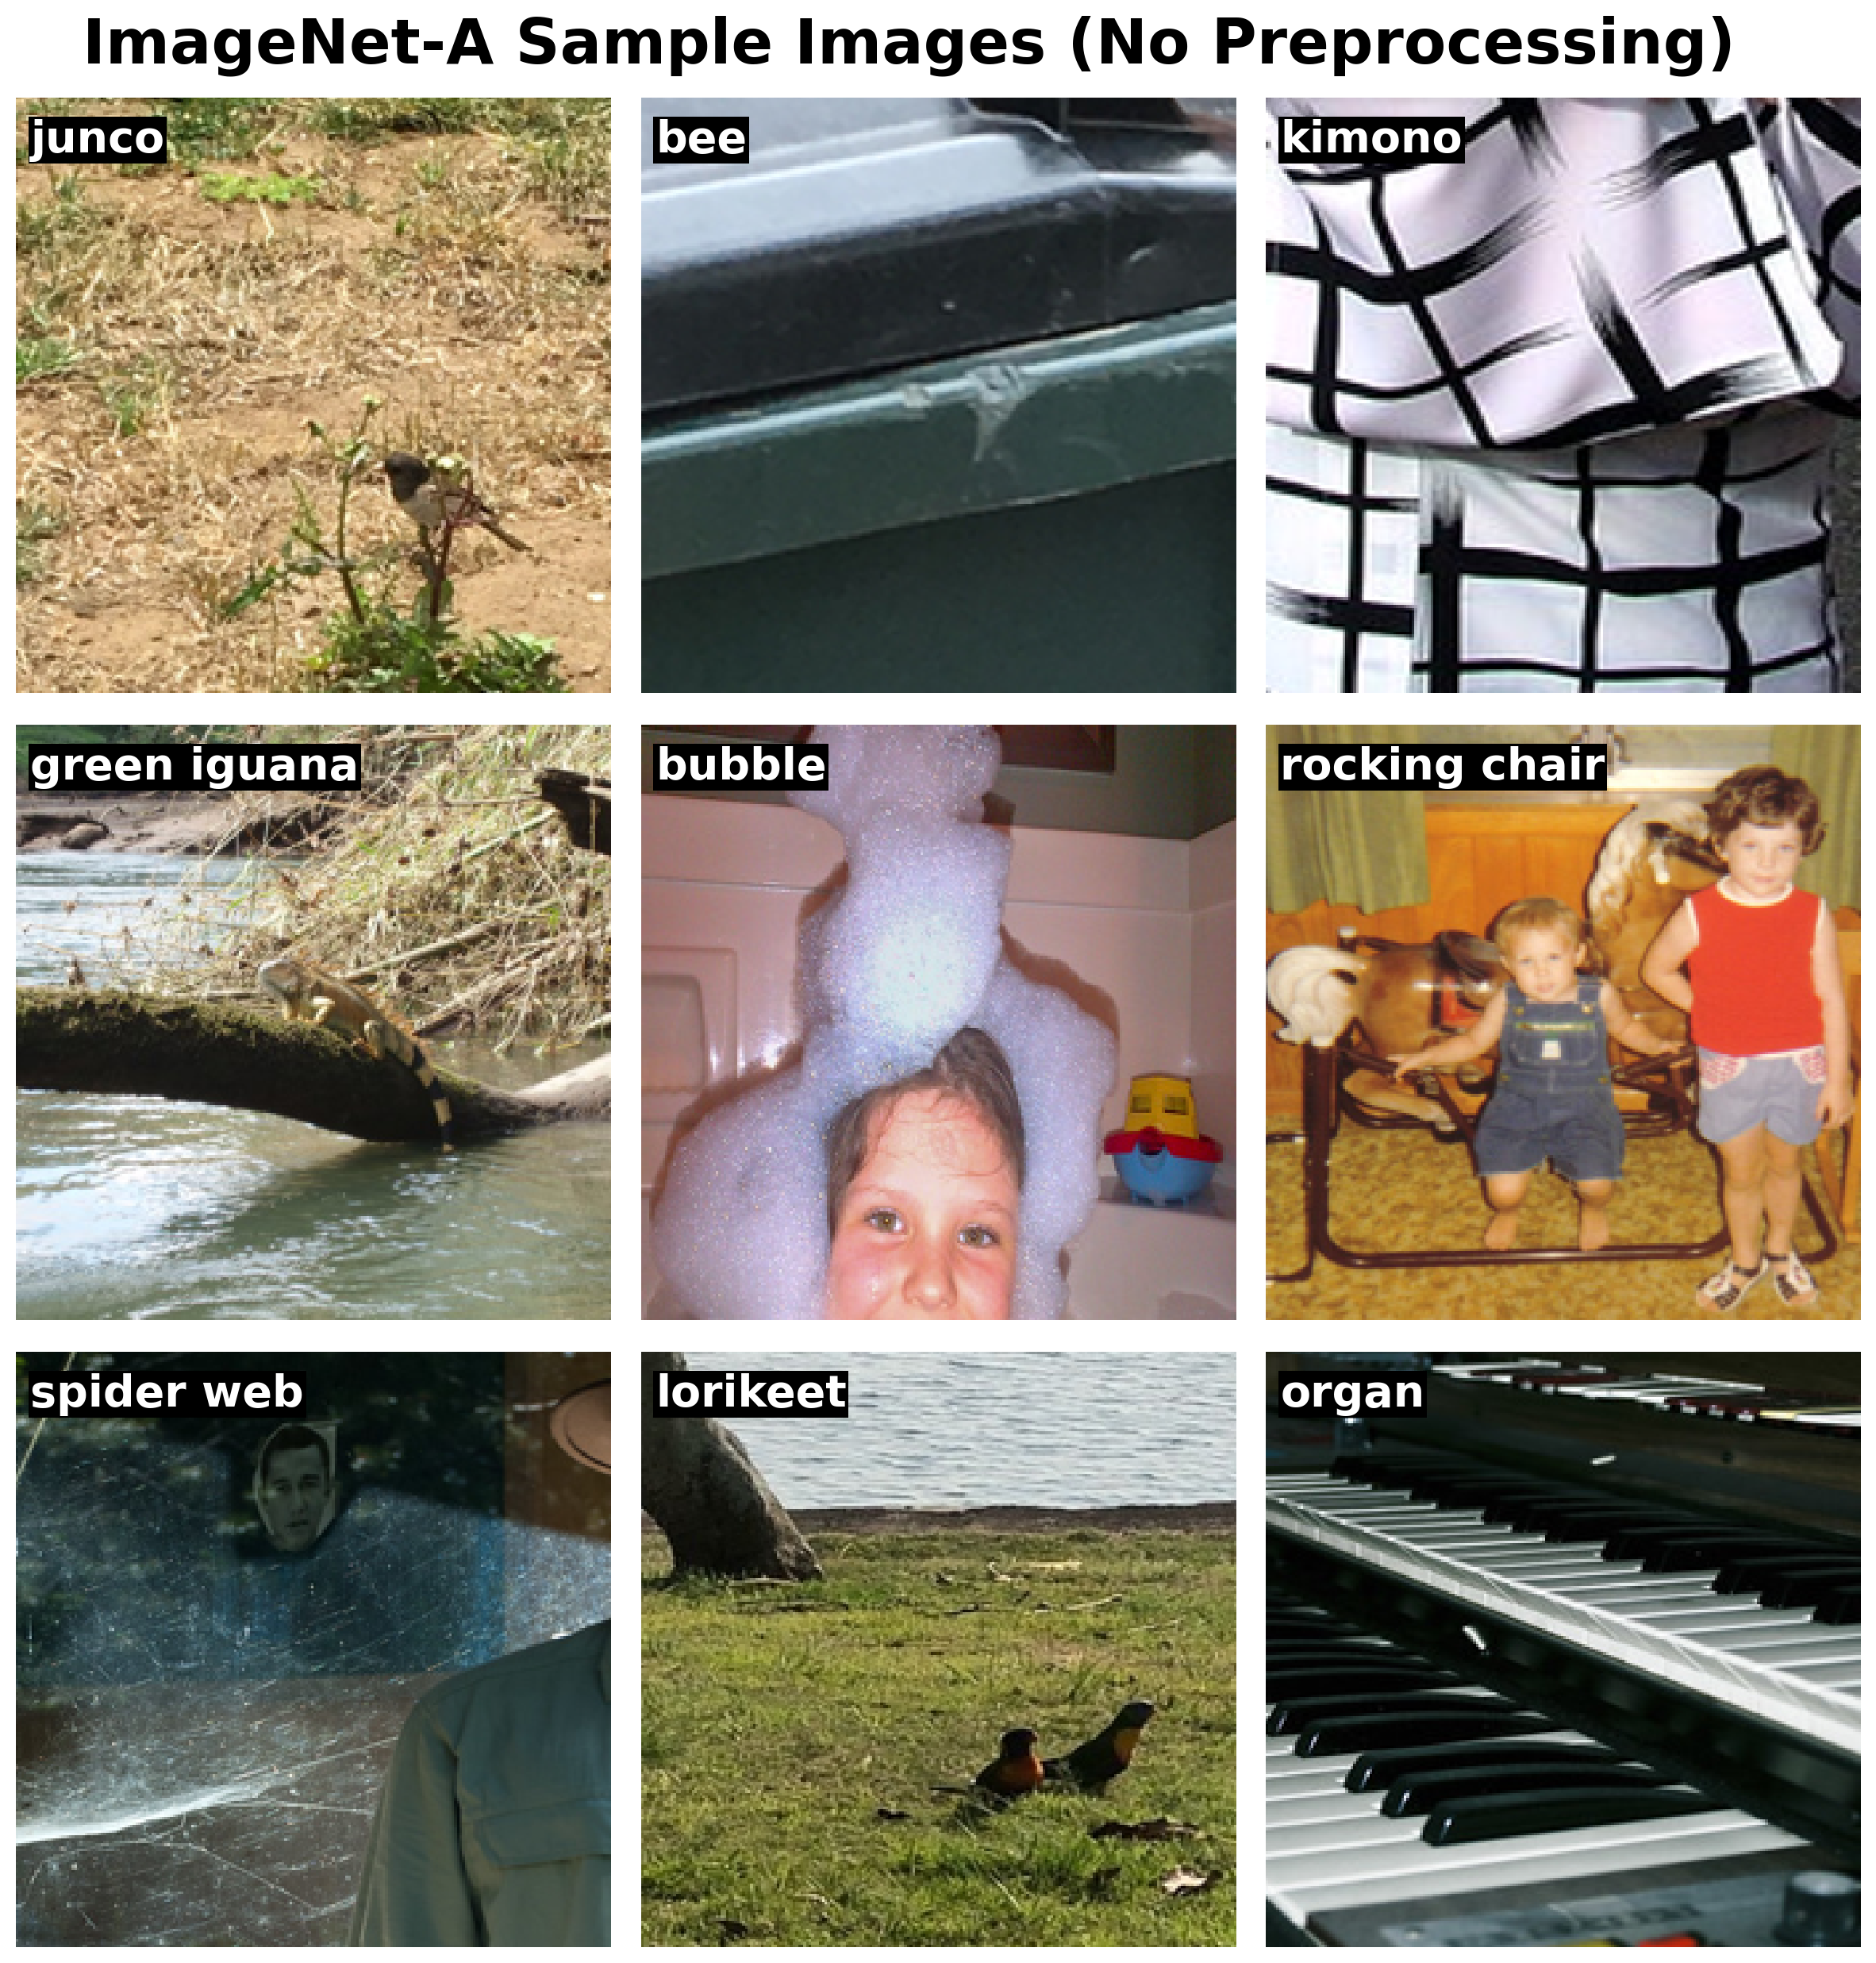

In [ ]:
# Display a grid of sample images from the dataset without preprocessing
plot_image_grid(data_loader_imageneta_no_preprocess, imageneta_classes, is_preprocessed=False)

#### 2.6.1 Visualizing Images With CLIP's Preprocessing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


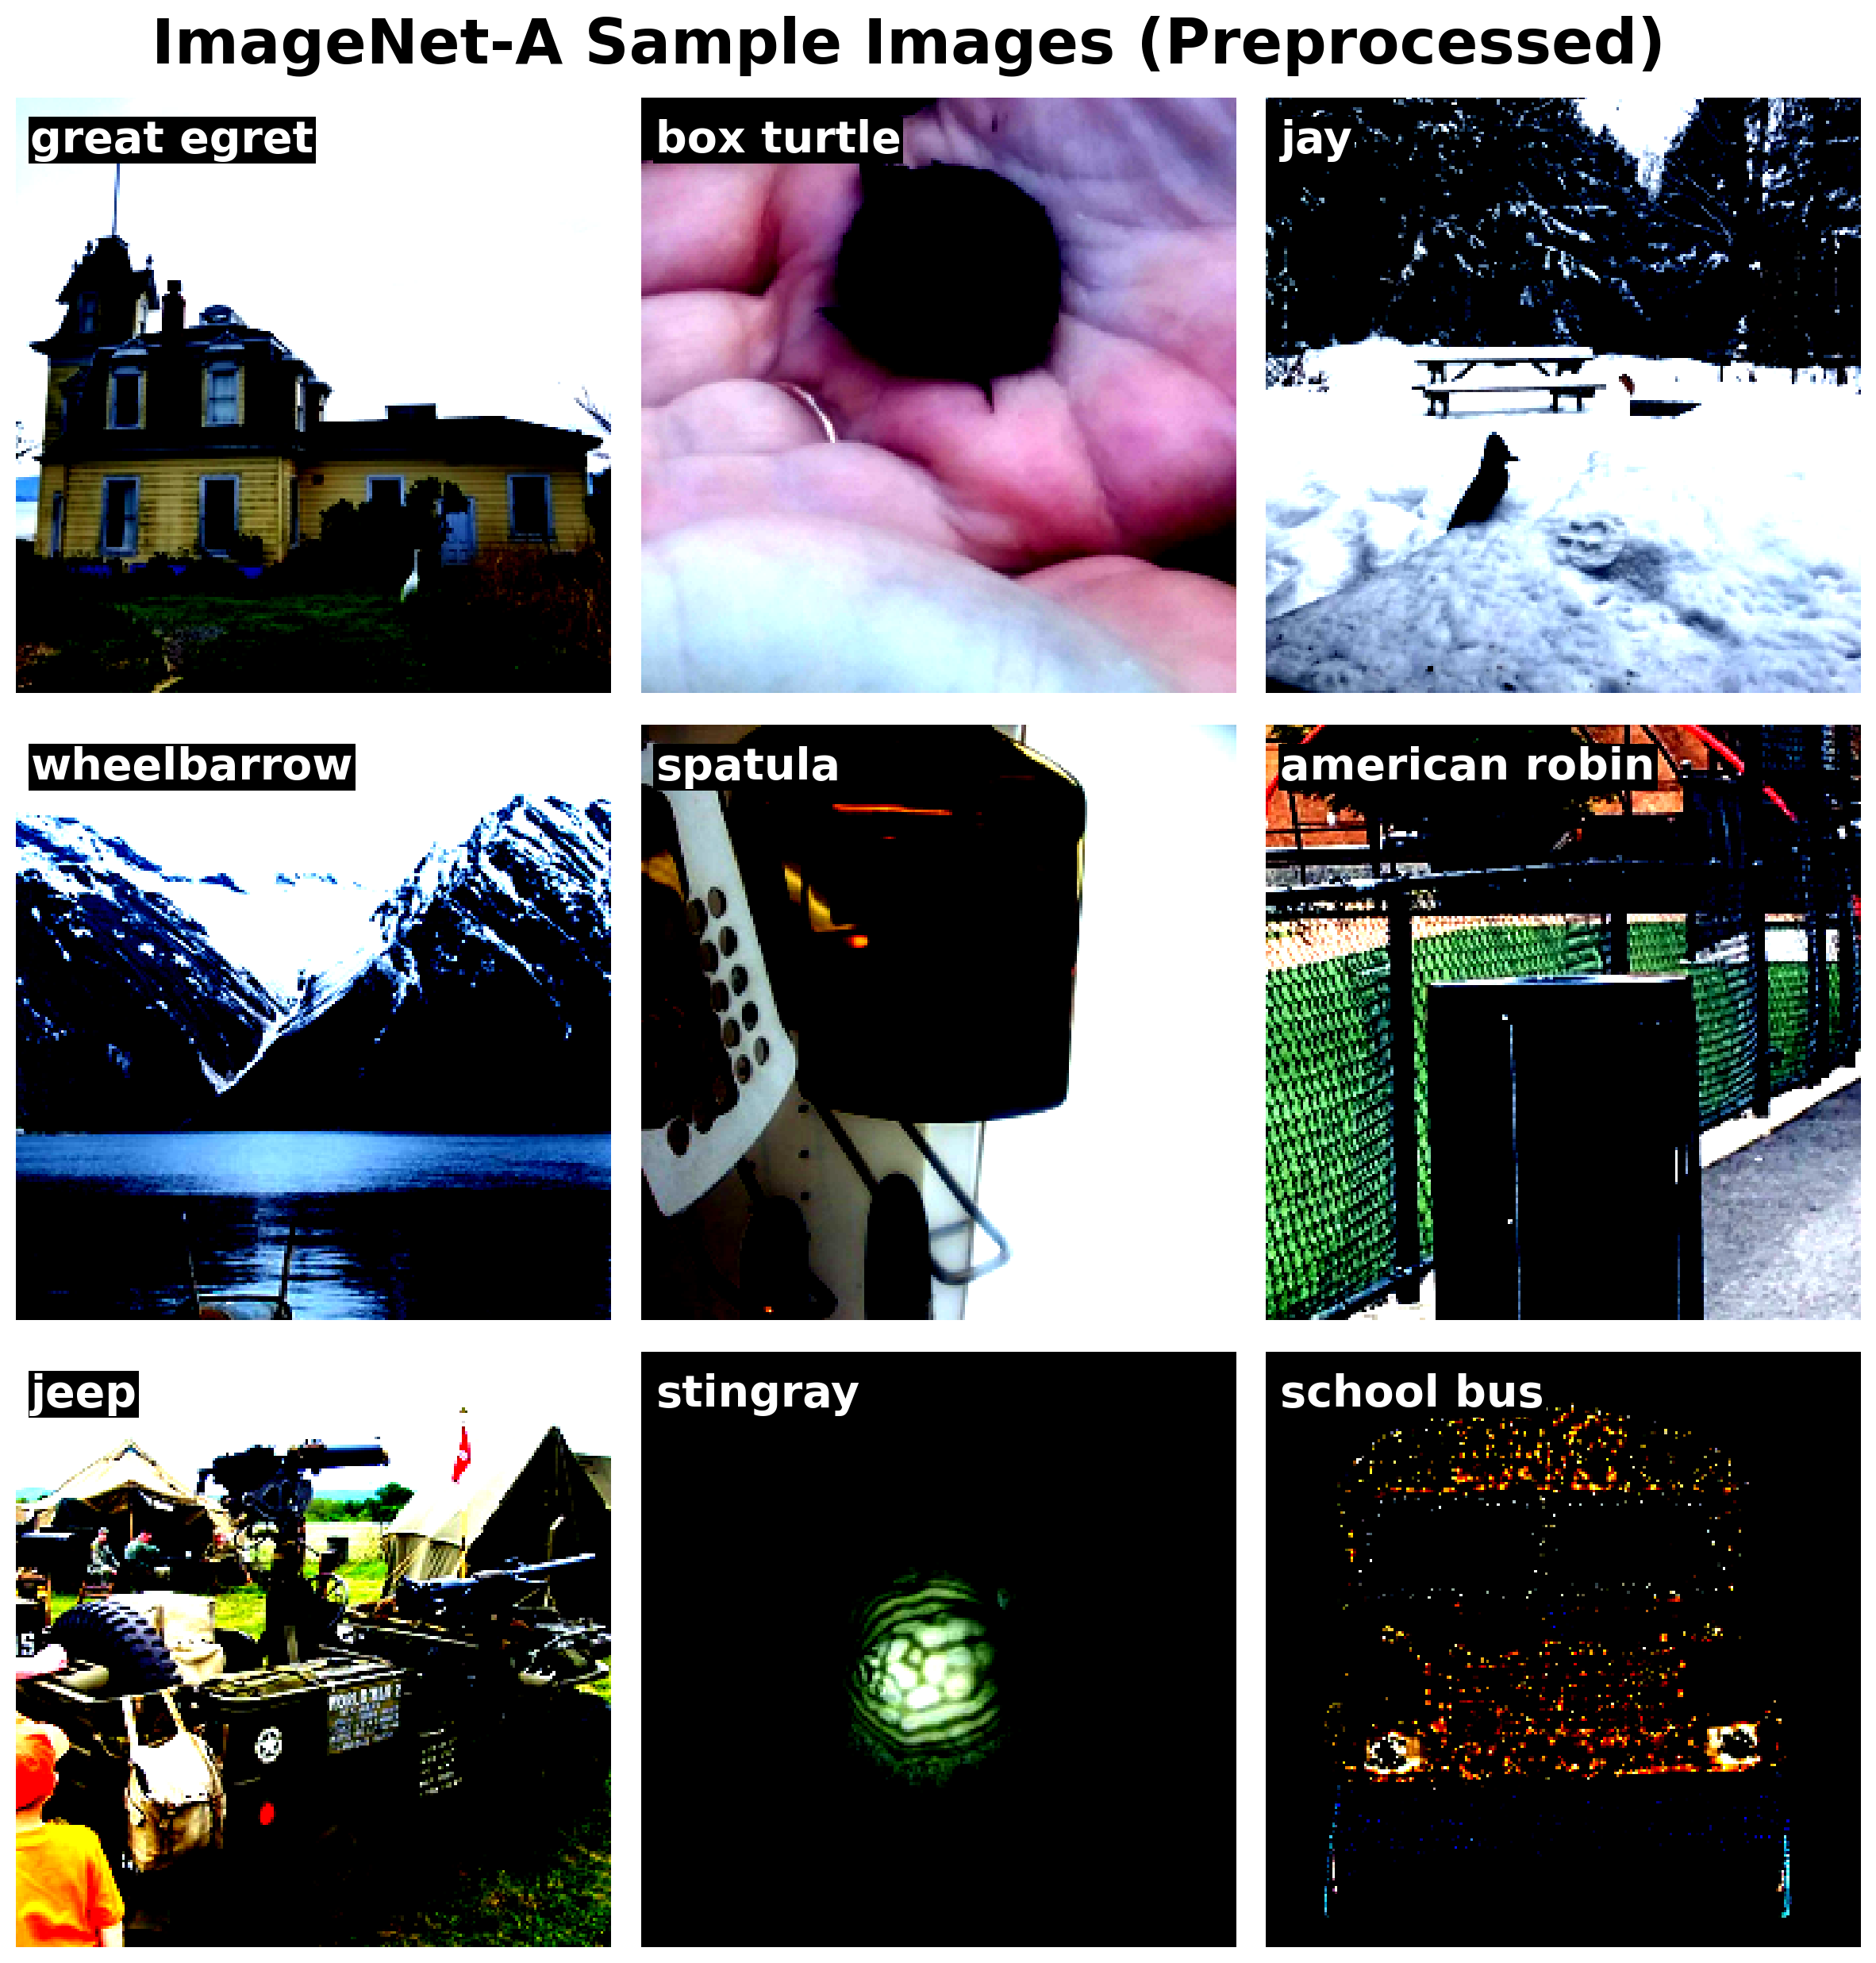

In [ ]:
# Display a grid of sample images from the dataset with preprocessing
plot_image_grid(data_loader_imageneta, imageneta_classes, is_preprocessed=True)

### 2.7 Dataset Statistics

Finally, let's print some statistics about our dataset.

In [ ]:
def print_dataset_stats(dataloader):
    """
    Print statistics about the dataset.

    Args:
        dataloader (DataLoader): The DataLoader to analyze.
    """
    num_samples = len(dataloader.dataset)  # Total number of samples in the dataset
    num_classes = len(imageneta_classes)  # Total number of classes

    # Print general dataset statistics
    print(f"Dataset Statistics:")
    print(f"Total number of samples: {num_samples}")
    print(f"Number of classes: {num_classes}")
    print(f"Batch size: {dataloader.batch_size}")
    print(f"Number of batches: {len(dataloader)}")

    # Attempt to get the first batch from the dataloader
    try:
        X, y = next(iter(dataloader))

        # Print the shape of the input tensor (X)
        # N: batch size, C: number of channels, H: height, W: width
        print(f"Input shape [N, C, H, W]: {X.shape}")

        # Print the shape and data type of the label tensor (y)
        print(f"Label shape: {y.shape}, dtype: {y.dtype}")
    except StopIteration:
        # Handle the case where the dataloader might be empty
        print("The DataLoader is empty.")

print_dataset_stats(data_loader_imageneta)

Dataset Statistics:
Total number of samples: 7500
Number of classes: 200
Batch size: 1
Number of batches: 7500
Input shape [N, C, H, W]: torch.Size([1, 3, 224, 224])
Label shape: torch.Size([1]), dtype: torch.int64


This comprehensive dataset preparation sets the stage for our TPT implementation. We've loaded the data, applied the necessary preprocessing and verified the dataset's integrity through visualization and statistics. In the next section, we'll move on to implementing the core TPT algorithm.

## 3. Zero-Shot Prediction with CLIP

Recent advances in vision-language pre-training, such as CLIP **[1]**, present a promising direction for developing foundation models for vision tasks. These foundation models encode a wide range of visual concepts after training on millions of noisy **image-text pairs** and can be applied to downstream tasks in a zero-shot manner without task-specific training data.

This is made possible by appropriately designed instruction prompts. For example, we can prepend a category name with a prompt “a photo of a" (e.g., “a
photo of a dog"). Images can then be classified by using CLIP to *measure their alignment* with the various class descriptions. Designing such prompts thus plays a crucial role in applying foundation models to downstream tasks in a zero-shot manner. However, such hand-crafted prompts require domain-specific heuristics and may not be optimal.

![Image](https://github.com/openai/CLIP/raw/main/CLIP.png)

The image above sums up the whole framework of CLIP:
+ First, a contrastive pre-training determines the relations between the components of the image encoded informations and the text encoder components.
+ In order to acheive Zero-Shot prediction, we create the encoding of our classes and feed it into the text encoder.
+ Finally, we predict the maximum cosine similarity between the image and our labels.

### 3.1 Load CLIP Model

In [ ]:
from clip import clip

# Load the CLIP model with ResNet50 backbone
model_zero_shot, _ = clip.load("RN50")

# Move the model to the appropriate device (GPU or CPU)
if device == "cuda":
  model_zero_shot = model_zero_shot.cuda().eval()
else:
  model_zero_shot = model_zero_shot.cpu().eval()

### 3.2 Class Name Embedding

We create text embeddings for our class names, which will be used for zero-shot classification.

In [ ]:
def embed_dataset_classnames(list_of_labels):
    """
    Create text embeddings for class names.

    Args:
    list_of_labels (dict): Dictionary of class indices and names

    Returns:
    tuple: Descriptions and their embeddings
    """
    # Create text descriptions for each class
    descriptions = [f"a photo of a {value}." for key, value in list_of_labels.items()]

    # Tokenize the descriptions and move to the appropriate device
    if device == "cuda":
      text_tokens = clip.tokenize(descriptions).cuda()
    else:
      text_tokens = clip.tokenize(descriptions).cpu()

    # Generate and normalize text embeddings
    with torch.no_grad():
        texts_z = model_zero_shot.encode_text(text_tokens).float()
        texts_z /= texts_z.norm(dim=-1, keepdim=True)

    return descriptions, texts_z

# Generate embeddings for ImageNet-A classes
embeddings, texts_z = embed_dataset_classnames(imageneta_classes)

print(f"Created embeddings for {len(embeddings)} classes")

Created embeddings for 200 classes


### 3.3 Zero-Shot Evaluation Function

This function performs zero-shot evaluation using CLIP, measuring how well the model can classify images into categories it hasn't been explicitly trained on, based solely on textual descriptions of those categories.

In [ ]:
def test_step_zero_shot_clip(net, data_loader, texts_z, device='cuda'):
    """
    Perform zero-shot evaluation on a dataset using CLIP.

    Args:
    net (nn.Module): The CLIP model
    data_loader (DataLoader): DataLoader for the test dataset
    texts_z (Tensor): Text embeddings of class names
    device (str): Device to run the evaluation on

    Returns:
    float: Accuracy percentage
    """
    samples = 0.0
    cumulative_accuracy = 0.0

    # Set the network to evaluation mode
    net.eval()

    with torch.no_grad():
        # Iterate over the test set
        for batch_idx, (inputs, targets) in tqdm(enumerate(data_loader), total=len(data_loader), position=0, leave=True):
            # Move inputs and targets to the specified device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Encode images
            images_z = net.encode_image(inputs).float()

            # Compute similarity and get predictions
            outputs = (100 * images_z @ texts_z.T).softmax(dim=-1)
            _, predicted = outputs.max(1)

            # Update accuracy
            samples += inputs.shape[0]
            cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_accuracy / samples * 100

Let's run it!

In [ ]:
set_seeds(0)
# # Perform zero-shot evaluation
test_accuracy = test_step_zero_shot_clip(model_zero_shot, data_loader_imageneta, texts_z, device=device)

print(f"Zero Shot CLIP accuracy: {test_accuracy:.2f}%")

Random seeds set to 0 for reproducibility.


100%|██████████| 7500/7500 [08:32<00:00, 14.64it/s]

Zero Shot CLIP accuracy: 21.65%


### 3.4 Analysis of Zero-Shot Results

The zero-shot accuracy achieved by CLIP on the ImageNet-A dataset demonstrates the power of
vision-language models in tackling complex visual tasks without task-specific training.

Key observations:
1. Flexibility: CLIP can classify images into categories it wasn't explicitly trained on.
2. Efficiency: No additional training is required for new tasks.
3. Interpretability: The use of natural language prompts provides insight into the model's decision-making.

Limitations to consider:
1. Domain Specificity: The model's performance may degrade on domains very different from its training data.
2. Lack of Fine-tuning: While impressive, zero-shot performance may not match task-specific fine-tuned models.

In the next section, we'll explore how Test-Time Prompt Tuning (TPT) can address some of these
limitations and further improve the model's performance on out-of-distribution data.


## 4. Test-Time Prompt Tuning (TPT)

### 4.1 TPT Model Overview

We now focus on the framework described in **[2]**.

The tuned prompt is adapted to each task, making it suitable for zero-shot generalization without requiring any task-specific
training data or annotations. TPT retains the zero-shot generalization setting since no additional training data or annotations are used.

![Image](https://github.com/azshue/TPT/blob/gh-pages/assets/tpt-intro.png?raw=true)

Because labels are not available for test time tuning, we must select
an unsupervised loss for prompt tuning. We design our TPT objective to promote the consistency
of the model’s predictions across different augmented views of a given test image.

Let's consider again the CLIP model. Let $\mathcal{F} = \{E_{visual}\,, E_{text}\},$ with $E_{visual}$ and $E_{text}$ being the image and text encoders, respectively.

Given the single test image $X_{test}$ and considering a $K-$ class classification problem, we
generate $N$ randomly augmented views of each test image using a family of random augmentations $\mathcal{A}$
and we minimize the entropy of the averaged prediction probability distribution

$p^* = arg \min_\mathcal{P}\; \mathcal{L}(\mathcal{F}, \mathcal{P}, X_{test}) = arg \min_\mathcal{P}\; [- \sum_{i = 1}^{K}{\widetilde{p}_\mathcal{P}(y_i \;|\; X_{test}) \log{{\widetilde{p}_\mathcal{P}(y_i \;|\; X_{test}}})}],$

where $\;\widetilde{p}_\mathcal{P}(y_i \;|\; X_{test}) = \frac{1}{N} \sum_{j = 1}^{N}{p_\mathcal{P}(y_i \;|\; \mathcal{A}_j(X_{test}))}$ and so
$\;\widetilde{p}_\mathcal{P}(y \;|\; \mathcal{A}_i(X_{test}))$ is the vector of class probabilities produced by the model when provided with prompt $\mathcal{P}$ and the $i-$th augmented view of the test image.

In order to reduce the noise from random augmentations, **[2]** introduces a *confidence selection* technique to filter out views that generate an high entropy prediction: recall that an high entropy means that the model has a low confidence in the prediction.
<br>
Considering the $N$ augmented views of an image $X_{test},$ we perform a simple statistical analysis comparing the self-entropies of each augmentation and ranking them from low to high entropy: given the hierarchy, we will consider next only the augmented views that are in the $\rho-$percentile, with $\rho$ parameter to set. This approach is equivalent to set a threshold $\tau$ and then consider only the augmentations that have a self-entropy smaller or equal than $\tau.$

Given that, we can rewrite averaged probability as

$\;\widetilde{p}_\mathcal{P}(y \;|\; X_{test}) = \frac{1}{\rho N} \sum_{i = 1}^{N}{\mathbb{1}\left[\pmb{H}\left(p_i\right) \leq \tau\right]\; p_\mathcal{P}(y \;|\; \mathcal{A}_i(X_{test}))},$

with $\mathbb{1}\left[\pmb{H}\left(p_i\right) \leq \tau\right]$ mask over the augmented samples and $\pmb{H}$ function measuring the self-entropy of the prediction on an augmented view.


For an in-depth review of the model, please refer to **[2]**.

### 4.2 Implementation

Our implementation is based on the original work by the authors of **[2]**. Let's break down the key components:

#### 4.3.1 Image Augmentation

The image augmentation component is crucial for creating diverse views of each test sample, enabling TPT to learn robust and consistent predictions across various image transformations. We implemented the image augmentation technique as a random cropping and horizontal flipping of the input images: each input is augmented by default 63 times.

In [ ]:
def augmentation(image, n_aug=64):
    """
    Generate multiple augmented versions of an image.

    Args:
    image (torch.Tensor): Input image tensor of shape (n_channels, height, width)
    n_aug (int): Number of augmented versions to generate

    Returns:
    torch.Tensor: Tensor of augmented images of shape (n_aug, n_channels, 224, 224)
    """
    # Define the size for cropping and resizing
    crop_size = 224

    # Repeat the input image n_aug times
    aug = image.repeat(n_aug, 1, 1, 1)

    # Initialize output tensor to store augmented images
    out = torch.zeros(n_aug, 3, crop_size, crop_size)

    # Set the first augmented image as the original
    out[0] = image

    # Define the augmentation transformations
    transform = v2.Compose([
        v2.RandomResizedCrop(crop_size),  # Randomly crop and resize the image
        v2.RandomHorizontalFlip(),        # Randomly flip the image horizontally
    ])

    # Apply transformations to create augmented versions
    for j in range(1, n_aug):
        out[j] = transform(aug[j])

    return out

#### 4.3.2 Custom Text Encoder

The custom text encoder is designed to process the learnable prompts and generate text features that can be compared with image features.

In [ ]:
class TextEncoder(nn.Module):
    """
    A custom text encoder that processes text prompts using components from the CLIP model.
    """

    def __init__(self, clip_model):
        """
        Initialize the text encoder with components from the CLIP model.

        Args:
        clip_model: The original CLIP model to extract components from
        """
        super().__init__()
        # Extract necessary components from the CLIP model
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection

    def forward(self, prompts, tokenized_prompts):
        """
        Process text prompts through the encoder.

        Args:
        prompts: The text prompts to encode
        tokenized_prompts: The tokenized prompts

        Returns:
        Encoded text features
        """
        # Add positional embeddings to the prompts
        x = prompts + self.positional_embedding

        # Permute dimensions for transformer input
        x = x.permute(1, 0, 2) # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]

        # Pass through the transformer
        x = self.transformer(x)

        # Permute dimensions back
        x = x.permute(1, 0, 2) # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]

        # Apply final layer normalization
        x = self.ln_final(x)

        # Select features from the EOT token and project
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

#### 4.3.3 Prompt Learner

The Prompt Learner is a crucial component of the Test-Time Prompt Tuning process: it's responsible for learning and generating context-aware prompts that adapt to each
specific test sample. This dynamic approach allows the model to fine-tune its
understanding of the input image in real-time, potentially improving classification
accuracy for out-of-distribution samples.

In [ ]:
# Import CLIP tokenizer
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

_tokenizer = _Tokenizer()

In [ ]:
class PromptLearner(nn.Module):
    """
    TPT Prompt Learner class.
    This class is responsible for learning and generating context-aware prompts
    for image classification tasks using the CLIP model.
    """

    def __init__(self, clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        """
        Initialize the Prompt Learner.

        Args:
        clip_model: The original CLIP model
        classnames: List of class names for the classification task
        n_ctx: Number of context tokens to use in the prompt
        ctx_init: Initial context string (if provided)
        class_token_position: Position of the class token in the prompt ("end", "middle", or "front")
        csc: Flag for using class-specific contexts
        """
        super().__init__()
        n_cls = len(classnames)
        ctx_dim = clip_model.ln_final.weight.shape[0]
        clip_imsize = clip_model.visual.input_resolution

        # Initialize context vectors
        if ctx_init:
            # Use given words to initialize context vectors
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = clip.tokenize(ctx_init).to(clip_model.token_embedding.weight.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            # Random initialization of context vectors
            if csc:
                print("Initializing class-specific contexts")
                ctx_vectors = torch.empty(n_cls, n_ctx, ctx_dim)
            else:
                print("Initializing a generic context")
                ctx_vectors = torch.empty(n_ctx, ctx_dim)
            # Initialize with small random values
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        print(f"Initial context: {prompt_prefix}")
        print(f"Number of context words (tokens): {n_ctx}")

        # Create a learnable parameter for context vectors
        self.ctx = nn.Parameter(ctx_vectors)

        # Process class names
        # Replace underscores with spaces in class names
        descriptions = [f"{value}" for key, value in classnames.items()]
        classnames = [name.replace("_", " ") for name in descriptions]
        print(f"Processed class names: {classnames}")
        # Get the length of each encoded class name
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        # Create prompts by combining prefix, class name, and a period
        prompts = [prompt_prefix + " " + name + "." for name in classnames]
        print(f"Generated prompts: {prompts}")

        # Tokenize prompts
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)

        # Register buffers for token prefix and suffix
        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS (Start of Sequence)
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS (Classification and End of Sequence)

        # Store various parameters for later use
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts
        self.name_lens = name_lens
        self.class_token_position = class_token_position

    def forward(self):
        """
        Generate prompts by combining learned context with class names.

        Returns:
        torch.Tensor: Generated prompts
        """
        ctx = self.ctx
        # If using CoOp (Context Optimization), expand the context for all classes
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix

        if self.class_token_position == "end":
            # Concatenate prefix, context, and suffix
            prompts = torch.cat(
                [
                    prefix,  # (n_cls, 1, dim)
                    ctx,     # (n_cls, n_ctx, dim)
                    suffix,  # (n_cls, *, dim)
                ],
                dim=1,
            )
        elif self.class_token_position == "middle":
            # Insert class token in the middle of the context
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)
        elif self.class_token_position == "front":
            # Place class token at the beginning of the context
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)
        else:
            raise ValueError("Invalid class_token_position. Must be 'end', 'middle', or 'front'.")

        return prompts

#### 4.3.4 Our Custom CLIP Model

This section defines a custom version of the CLIP model that incorporates the Prompt Learner
and the custom Text Encoder. This modification allows for test-time prompt tuning,
potentially improving performance on out-of-distribution samples.

In [ ]:
class OurCLIP(nn.Module):
    def __init__(self, classnames, n_ctx, ctx_init, class_token_position, csc=False):
        """
        Initialize our custom CLIP model.

        Args:
        classnames (list): List of class names for the classification task
        n_ctx (int): Number of context tokens to use in the prompt
        ctx_init (str): Initial context string
        class_token_position (str): Position of the class token in the prompt
        csc (bool): Flag for using class-specific contexts
        """
        super().__init__()
        # Load the original CLIP model (ResNet50 version)
        clip_model, _ = clip.load("RN50")
        clip_model = clip_model.float()  # Convert to float for compatibility

        # Initialize our custom components
        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx, ctx_init, class_token_position, csc=csc)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.image_encoder = clip_model.visual  # Use CLIP's original image encoder
        self.text_encoder = TextEncoder(clip_model)  # Use our custom text encoder
        self.logit_scale = clip_model.logit_scale  # CLIP's logit scale parameter

    def forward(self, image):
        """
        Forward pass of the model.

        Args:
        image (torch.Tensor): Input image tensor

        Returns:
        torch.Tensor: Logits for classification
        """
        # Encode the input image
        image_features = self.image_encoder(image)

        # Generate prompts and encode them
        prompts = self.prompt_learner()
        tokenized_prompts = self.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)

        # Normalize feature vectors
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute logits using CLIP's logit scale
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

Now, we redefine the embedding of class names, allowing for flexibility
in running only the Test-Time Prompt Tuning part if needed.

In [ ]:
def embed_dataset_classnames(list_of_labels):
    """
    Create text embeddings for class names.

    Args:
    list_of_labels (dict): Dictionary of class indices and names

    Returns:
    tuple: Descriptions and their embeddings
    """
    # Create text descriptions for each class
    descriptions = [f"a photo of a {value}." for key, value in imageneta_classes.items()]

    # Tokenize the descriptions and move to the appropriate device
    if device == "cuda":
        text_tokens = clip.tokenize(descriptions).cuda()
    else:
        text_tokens = clip.tokenize(descriptions).cpu()

    # Generate and normalize text embeddings
    with torch.no_grad():
        texts_z = model_zero_shot.encode_text(text_tokens).float()
        texts_z /= texts_z.norm(dim=-1, keepdim=True)

    return descriptions, texts_z

In [ ]:
# Generate embeddings for ImageNet-A classes
embeddings, texts_z = embed_dataset_classnames(imageneta_classes)
print(f"Shape of text embeddings: {texts_z.shape}")

Shape of text embeddings: torch.Size([200, 1024])


The shape of texts_z is torch.Size([200, 1024]). This means:
- We have 200 classes, corresponding to the 200 categories in ImageNet-A.
- Each class is represented by a 1024-dimensional embedding vector.

This high-dimensional representation (1024D) allows the model to capture complex semantic relationships
between different classes. The use of such a large embedding space enables fine-grained distinctions
between classes and potentially improves the model's ability to generalize to unseen examples.

The number of classes (200) matches the ImageNet-A dataset, which is a subset of the full ImageNet,
designed to be particularly challenging for image classification models.

#### 4.3.5 Confidence Selection Technique

This technique is used to filter out low-confidence predictions, focusing the learning process
on more reliable samples. It's a key component in improving the robustness of the model.


In [ ]:
def select_confident_samples(logits, top):
    """
    Select the most confident predictions based on their entropy.

    Args:
    logits (torch.Tensor): Raw model outputs (before softmax)
    top (float): Fraction of samples to select (e.g., 0.1 for top 10%)

    Returns:
    tuple: Selected logits and their indices
    """
    # Calculate the entropy of each prediction
    # Lower entropy indicates higher confidence
    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)

    # Sort the entropies and select the top fraction with lowest entropy
    num_to_select = int(batch_entropy.size(0) * top)
    idx = torch.argsort(batch_entropy, descending=False)[:num_to_select]

    # Return the selected logits and their indices
    return logits[idx], idx

#### 4.3.6 Entropy Averaging

This implementation of entropy averaging provides higher numerical stability
compared to a naive implementation. It's crucial for reliable optimization
during the test-time adaptation process.

In [ ]:
def avg_entropy(outputs):
    """
    Compute the average entropy of the predictions in a numerically stable way.

    Args:
    outputs (torch.Tensor): Model outputs (logits)

    Returns:
    torch.Tensor: Average entropy
    """
    # Normalize logits to avoid numerical instability
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)

    # Compute average logits
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])

    # Clamp values to avoid log(0) issues
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)

    # Compute and return the entropy
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

#### 4.3.7 Optimizer Selection

In line with the approach described in **[2]** (Shu et al., 2022), we have chosen the AdamW optimizer
for our TPT implementation.

In [ ]:
def get_optimizer(model, lr):
    """
    Create an AdamW optimizer for the model.

    Args:
    model (nn.Module): The model whose parameters will be optimized
    lr (float): Learning rate for the optimizer

    Returns:
    torch.optim.Optimizer: AdamW optimizer instance
    """
    optimizer = torch.optim.AdamW([
        {"params": model.parameters()}
    ], lr=lr)

    return optimizer

Notes on the optimizer choice:

1. AdamW vs Adam: AdamW decouples the weight decay from the gradient update which can lead
   to better generalization, especially in fine-tuning scenarios like TPT.

2. Learning Rate: The learning rate (lr) is a crucial hyperparameter. In TPT, we typically
   use a smaller learning rate compared to full model training to avoid overfitting to a
   single test sample.

3. Parameter Groups: While this implementation optimizes all model parameters, in practice
   we might only want to optimize the prompt-related parameters. This can be achieved by
   modifying the parameter dictionary passed to AdamW.

4. Weight Decay: AdamW allows for easy incorporation of weight decay. If needed, a weight_decay
   parameter can be added to the AdamW constructor for additional regularization.

The choice of AdamW aligns with current best practices in prompt tuning and helps in achieving
stable and effective optimization during the test-time adaptation process.

#### 4.3.8 The Training Loop

This function adapts the prompts for each test sample individually, aiming to improve the model's performance on out-of-distribution data.

In [ ]:
def test_time_tuning_step_(net, data_loader, learning_rate, steps=1, device="cuda:0", top=0.1, n_aug=64):
    """
    Perform test-time tuning on the network for each sample in the dataset.

    Args:
    net (nn.Module): The network to be tuned
    data_loader (DataLoader): DataLoader for the test set
    learning_rate (float): Learning rate for optimization
    steps (int): Number of optimization steps per sample
    device (str): Device to run computations on
    top (float): Fraction of confident samples to select
    n_aug (int): Number of augmentations per sample

    Returns:
    float: Accuracy of the tuned model on the test set
    """
    # Save initial state of the network
    torch.save(net.state_dict(), 'init_network.pt')

    max_tests = len(data_loader)
    good_pred = 0

    # Iterate over the dataset
    for batch_idx, (inputs, targets) in tqdm(enumerate(data_loader), total=max_tests):
        # Reset the network to its initial state for each new sample
        net.load_state_dict(torch.load('init_network.pt'))

        # Initialize optimizer for the current sample
        optimizer = get_optimizer(net, learning_rate)

        # Move data to the specified device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Generate augmented versions of the input
        inputs_aug = augmentation(inputs, n_aug).to(device)

        # Perform optimization steps
        for _ in range(steps):
            # Generate augmented versions of the input
            inputs_aug = augmentation(inputs, n_aug).to(device)

            # Forward pass
            net.eval()
            outputs = net(inputs_aug)

            # Apply confidence selection
            outputs, _ = select_confident_samples(outputs, top)

            # Compute loss
            net.train()
            loss = avg_entropy(outputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Evaluate on the original (non-augmented) input
        net.eval()
        pred = net(inputs)
        pred = (pred.max(dim=1))[1]
        # Check if prediction is correct
        if imageneta_classes[targets.item()] == imageneta_classes[pred.item()]:
            good_pred += 1

        # Print progress every 500 samples
        if ((batch_idx + 1) % 500 == 0):
            current_accuracy = 100 * float(good_pred) / float(batch_idx + 1)
            print(f"Test n. {batch_idx + 1}")
            print(f"Current accuracy: {current_accuracy:.2f}%")

        # Clean up to free memory
        del inputs, inputs_aug, targets
        torch.cuda.empty_cache()

    # Compute and print final accuracy
    final_accuracy = 100 * float(good_pred) / float(max_tests)
    print(f"Final accuracy: {final_accuracy:.2f}% ({good_pred} out of {max_tests} correct)")

    return final_accuracy

#### 4.3.9 Original TPT Experiment

This function sets up and runs the complete Test-Time Prompt Tuning experiment.
It initializes the model, configures the parameters, and executes the test-time tuning process.


In [ ]:
def original_tpt(
    classes=imageneta_classes,
    device="cuda:0",
    learning_rate=0.005,
    steps=1,
    n_ctx=4,
    ctx_init="a photo of a",
    class_token_position="end",
    csc=False,
    data_loader=data_loader_imageneta
):
    """
    Run the original Test-Time Prompt Tuning (TPT) experiment.

    Args:
    classes (dict): Dictionary of class names (default: imageneta_classes)
    device (str): Device to run computations on (default: "cuda:0")
    learning_rate (float): Learning rate for optimization (default: 0.005)
    steps (int): Number of optimization steps per sample (default: 1)
    run_name (str): Name of the experiment run (default: "exp1")
    n_ctx (int): Number of context tokens (default: 4)
    ctx_init (str): Initial context string (default: "a photo of a")
    class_token_position (str): Position of the class token (default: "end")
    csc (bool): Flag for using class-specific contexts (default: False)
    data_loader (DataLoader): DataLoader for the test set (default: data_loader_imageneta)

    Returns:
    float: Final accuracy of the TPT process
    """
    # Instantiate the custom CLIP model and move it to the specified device
    net = OurCLIP(
        classnames=classes,
        n_ctx=n_ctx,
        ctx_init=ctx_init,
        class_token_position=class_token_position,
        csc=csc
    ).to(device)

    print("Configuring gradients for TPT...")
    # Disable gradients for all parameters except those in the prompt learner
    for name, param in net.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)
        else:
            print(f"  Gradients enabled for: {name}")

    # Print model statistics
    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Run the test-time tuning process
    final_accuracy = test_time_tuning_step_(
        net,
        data_loader,
        learning_rate,
        steps=steps,
        device=device,
        top=0.1,
        n_aug=64
    )

    del net
    torch.cuda.empty_cache()

    return final_accuracy

In [ ]:
set_seeds(0)
print("Starting Test-Time Prompt Tuning experiment...")
accuracy = original_tpt(device=device)
print(f"Experiment completed. Final accuracy: {accuracy:.2f}%")

Random seeds set to 0 for reproducibility.
Starting Test-Time Prompt Tuning experiment...
Initial context: a photo of a
Number of context words (tokens): 4
Processed class names: ['stingray', 'goldfinch', 'junco', 'american robin', 'jay', 'bald eagle', 'vulture', 'newt', 'american bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'american alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'chihuahua', 'golden retriever', 'rottweiler', 'german shepherd dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'american black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white

  0%|          | 0/7500 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  7%|▋         | 500/7500 [15:21<3:34:50,  1.84s/it]

Test n. 500
Current accuracy: 22.60%


 13%|█▎        | 1000/7500 [30:41<3:18:54,  1.84s/it]

Test n. 1000
Current accuracy: 23.00%


 20%|██        | 1500/7500 [46:02<3:04:41,  1.85s/it]

Test n. 1500
Current accuracy: 23.07%


 27%|██▋       | 2000/7500 [1:01:27<2:49:35,  1.85s/it]

Test n. 2000
Current accuracy: 23.30%


 33%|███▎      | 2500/7500 [1:16:53<2:34:21,  1.85s/it]

Test n. 2500
Current accuracy: 23.64%


 40%|████      | 3000/7500 [1:32:16<2:17:39,  1.84s/it]

Test n. 3000
Current accuracy: 23.50%


 47%|████▋     | 3500/7500 [1:47:38<2:03:02,  1.85s/it]

Test n. 3500
Current accuracy: 23.29%


 53%|█████▎    | 4000/7500 [2:02:59<1:47:30,  1.84s/it]

Test n. 4000
Current accuracy: 23.62%


 60%|██████    | 4500/7500 [2:18:19<1:32:18,  1.85s/it]

Test n. 4500
Current accuracy: 23.60%


 67%|██████▋   | 5000/7500 [2:33:41<1:16:21,  1.83s/it]

Test n. 5000
Current accuracy: 23.88%


 73%|███████▎  | 5500/7500 [2:49:00<1:00:55,  1.83s/it]

Test n. 5500
Current accuracy: 23.84%


 80%|████████  | 6000/7500 [3:04:18<45:48,  1.83s/it]  

Test n. 6000
Current accuracy: 23.88%


 87%|████████▋ | 6500/7500 [3:19:46<31:01,  1.86s/it]

Test n. 6500
Current accuracy: 23.94%


 93%|█████████▎| 7000/7500 [3:35:13<15:19,  1.84s/it]

Test n. 7000
Current accuracy: 23.89%


100%|██████████| 7500/7500 [3:50:34<00:00,  1.84s/it]

Test n. 7500
Current accuracy: 23.88%
Final accuracy: 23.88% (1791 out of 7500 correct)
Experiment completed. Final accuracy: 23.88%


## 5. TPT Variations

In this section, we explore various modifications to the original Test-Time Prompt Tuning (TPT) approach.
These variations aim to investigate different aspects of the model's adaptability and to potentially
improve its performance on out-of-distribution samples.

We will examine several variations, each designed to explore a different aspect of the TPT process.

1. TPT with Trainable Image Encoder: this variation allows both the prompt parameters and the image
   encoder parameters to be updated during the test-time adaptation process.

2. TPT with modified augmentation: we consider the original TPT and we modify the augmentation technique introducing a random vertical flip.

3. TPT with Augmix augmentation: we use the AugMix augmentation technique, introduced in **[4]**.

By exploring these variations, we aim to gain insights into the flexibility and robustness of the TPT
approach and to identify potential improvements for the original method.

### 5.1 TPT with Trainable Image Encoder

This variation of TPT allows both the prompt parameters and the image encoder parameters
to be updated during the test-time adaptation process. By doing so, we aim to explore
whether this additional flexibility can lead to improved performance on out-of-distribution samples.

Key differences from the original TPT implementation:
1. The image encoder parameters are now trainable.
2. A lower learning rate (0.000005) is used to compensate for the increased number of trainable parameters.

Below the implementation of this TPT variation:

In [ ]:
def first_tpt(
    classes=imageneta_classes,
    device="cuda:0",
    learning_rate=0.000005,  # Modified learning rate
    steps=1,
    n_ctx=4,
    ctx_init="a photo of a",
    class_token_position="end",
    csc=False,
    data_loader=data_loader_imageneta
):
    """
    Run the modified Test-Time Prompt Tuning (TPT) experiment.

    Args:
    classes (dict): Dictionary of class names (default: imageneta_classes)
    device (str): Device to run computations on (default: "cuda:0")
    learning_rate (float): Learning rate for optimization (default: 0.000005)
    steps (int): Number of optimization steps per sample (default: 1)
    n_ctx (int): Number of context tokens (default: 4)
    ctx_init (str): Initial context string (default: "a photo of a")
    class_token_position (str): Position of the class token (default: "end")
    csc (bool): Flag for using class-specific contexts (default: False)
    data_loader (DataLoader): DataLoader for the test set (default: data_loader_imageneta)

    Returns:
    float: Final accuracy of the TPT process
    """
    # Instantiate the custom CLIP model and move it to the specified device
    net = OurCLIP(
        classnames=classes,
        n_ctx=n_ctx,
        ctx_init=ctx_init,
        class_token_position=class_token_position,
        csc=csc
    ).to(device)

    print("Configuring gradients for TPT...")
    # Disable gradients for all parameters except those in the prompt learner and image encoder
    for name, param in net.named_parameters():
        if "prompt_learner" not in name and "image_encoder" not in name:
            param.requires_grad_(False)
        else:
            print(f"  Gradients enabled for: {name}")

    # Print model statistics
    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    #print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

    # Run the test-time tuning process
    final_accuracy = test_time_tuning_step_(
        net,
        data_loader,
        learning_rate,
        steps=steps,
        device=device,
        top=0.1,
        n_aug=64
    )

    del net
    torch.cuda.empty_cache()

    return final_accuracy

In [ ]:
set_seeds(0)
print("Starting Test-Time Prompt Tuning experiment...")
accuracy = first_tpt(device=device)
print(f"Experiment completed. Final accuracy: {accuracy:.2f}%")

Random seeds set to 0 for reproducibility.
Starting Test-Time Prompt Tuning experiment...
Initial context: a photo of a
Number of context words (tokens): 4
Processed class names: ['stingray', 'goldfinch', 'junco', 'american robin', 'jay', 'bald eagle', 'vulture', 'newt', 'american bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'american alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'chihuahua', 'golden retriever', 'rottweiler', 'german shepherd dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'american black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white

  7%|▋         | 500/7500 [19:34<4:32:39,  2.34s/it]

Test n. 500
Current accuracy: 24.80%


 13%|█▎        | 1000/7500 [39:07<4:13:12,  2.34s/it]

Test n. 1000
Current accuracy: 24.00%


 20%|██        | 1500/7500 [58:44<3:55:22,  2.35s/it]

Test n. 1500
Current accuracy: 23.67%


 27%|██▋       | 2000/7500 [1:18:18<3:35:43,  2.35s/it]

Test n. 2000
Current accuracy: 24.05%


 33%|███▎      | 2500/7500 [1:37:51<3:15:11,  2.34s/it]

Test n. 2500
Current accuracy: 24.20%


 40%|████      | 3000/7500 [1:57:25<2:55:13,  2.34s/it]

Test n. 3000
Current accuracy: 24.17%


 47%|████▋     | 3500/7500 [2:16:55<2:35:54,  2.34s/it]

Test n. 3500
Current accuracy: 23.77%


 53%|█████▎    | 4000/7500 [2:36:28<2:16:38,  2.34s/it]

Test n. 4000
Current accuracy: 23.98%


 60%|██████    | 4500/7500 [2:56:04<1:57:09,  2.34s/it]

Test n. 4500
Current accuracy: 24.16%


 67%|██████▋   | 5000/7500 [3:15:34<1:37:21,  2.34s/it]

Test n. 5000
Current accuracy: 24.34%


 73%|███████▎  | 5500/7500 [3:35:04<1:17:42,  2.33s/it]

Test n. 5500
Current accuracy: 24.53%


 80%|████████  | 6000/7500 [3:54:34<58:23,  2.34s/it]  

Test n. 6000
Current accuracy: 24.68%


 87%|████████▋ | 6500/7500 [4:14:04<38:53,  2.33s/it]

Test n. 6500
Current accuracy: 24.80%


 93%|█████████▎| 7000/7500 [4:33:35<19:30,  2.34s/it]

Test n. 7000
Current accuracy: 24.70%


100%|██████████| 7500/7500 [4:53:06<00:00,  2.34s/it]

Test n. 7500
Current accuracy: 24.64%
Final accuracy: 24.64% (1848 out of 7500 correct)
Experiment completed. Final accuracy: 24.64%


### 5.2 TPT with modified augmentation

Let's reconsider the original TPT experiment. We introduce an additional step in the augmentation technique: a random vertical flip for the augmented view of the test image.

In [ ]:
def augmix_tpt(
    classes=imageneta_classes,
    device="cuda:0",
    learning_rate=0.005,
    steps=1,
    n_ctx=4,
    ctx_init="a photo of a",
    class_token_position="end",
    csc=False,
    data_loader=data_loader_imageneta
):
    """
    Run the modified Test-Time Prompt Tuning (TPT) experiment.

    Args:
    classes (dict): Dictionary of class names (default: imageneta_classes)
    device (str): Device to run computations on (default: "cuda:0")
    learning_rate (float): Learning rate for optimization (default: 0.005)
    steps (int): Number of optimization steps per sample (default: 1)
    n_ctx (int): Number of context tokens (default: 4)
    ctx_init (str): Initial context string (default: "a photo of a")
    class_token_position (str): Position of the class token (default: "end")
    csc (bool): Flag for using class-specific contexts (default: False)
    data_loader (DataLoader): DataLoader for the test set (default: data_loader_imageneta)

    Returns:
    float: Final accuracy of the TPT process
    """
    # Instantiate the custom CLIP model and move it to the specified device
    net = OurCLIP(
        classnames=classes,
        n_ctx=n_ctx,
        ctx_init=ctx_init,
        class_token_position=class_token_position,
        csc=csc
    ).to(device)

    print("Configuring gradients for TPT...")
    # Disable gradients for all parameters except those in the prompt learner
    for name, param in net.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)
        else:
            print(f"  Gradients enabled for: {name}")

    # Print model statistics
    total_params = sum(p.numel() for p in net.parameters())
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    #print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")

    # Run the test-time tuning process
    final_accuracy = test_time_tuning_step_(
        net,
        data_loader,
        learning_rate,
        steps=steps,
        device=device,
        top=0.1,
        n_aug=64
    )

    del net
    torch.cuda.empty_cache()

    return final_accuracy

In [ ]:
def augmentation(image, n_aug=64):
    """
    Generate multiple augmented versions of an image.

    Args:
    image (torch.Tensor): Input image tensor of shape (n_channels, height, width)
    n_aug (int): Number of augmented versions to generate

    Returns:
    torch.Tensor: Tensor of augmented images of shape (n_aug, n_channels, 224, 224)
    """
    # Define the size for cropping and resizing
    crop_size = 224

    # Repeat the input image n_aug times
    aug = image.repeat(n_aug, 1, 1, 1)

    # Initialize output tensor to store augmented images
    out = torch.zeros(n_aug, 3, crop_size, crop_size)

    # Set the first augmented image as the original
    out[0] = image

    # Define the transformation
    transform = v2.Compose([v2.RandomResizedCrop(crop_size),
                         v2.RandomHorizontalFlip(),
                         v2.RandomVerticalFlip(),
                         ])

    # Apply transformations to create augmented versions
    for j in range(1, n_aug):
        out[j] = transform(aug[j])

    return out

In [ ]:
set_seeds(0)
print("Starting Test-Time Prompt Tuning experiment...")
accuracy = augmix_tpt(device=device)
print(f"Experiment completed. Final accuracy: {accuracy:.2f}%")

Random seeds set to 0 for reproducibility.
Starting Test-Time Prompt Tuning experiment...
Initial context: a photo of a
Number of context words (tokens): 4
Processed class names: ['stingray', 'goldfinch', 'junco', 'american robin', 'jay', 'bald eagle', 'vulture', 'newt', 'american bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'american alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'chihuahua', 'golden retriever', 'rottweiler', 'german shepherd dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'american black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white

  0%|          | 0/7500 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  7%|▋         | 500/7500 [16:59<3:57:06,  2.03s/it]

Test n. 500
Current accuracy: 20.40%


 13%|█▎        | 1000/7500 [33:56<3:40:23,  2.03s/it]

Test n. 1000
Current accuracy: 21.10%


 20%|██        | 1500/7500 [50:55<3:23:31,  2.04s/it]

Test n. 1500
Current accuracy: 21.87%


 27%|██▋       | 2000/7500 [1:07:54<3:06:40,  2.04s/it]

Test n. 2000
Current accuracy: 22.00%


 33%|███▎      | 2500/7500 [1:24:53<2:49:41,  2.04s/it]

Test n. 2500
Current accuracy: 22.08%


 40%|████      | 3000/7500 [1:41:52<2:32:48,  2.04s/it]

Test n. 3000
Current accuracy: 22.23%


 47%|████▋     | 3500/7500 [1:58:51<2:16:06,  2.04s/it]

Test n. 3500
Current accuracy: 22.00%


 53%|█████▎    | 4000/7500 [2:15:51<1:58:11,  2.03s/it]

Test n. 4000
Current accuracy: 22.23%


 60%|██████    | 4500/7500 [2:32:50<1:41:35,  2.03s/it]

Test n. 4500
Current accuracy: 22.42%


 67%|██████▋   | 5000/7500 [2:49:49<1:24:34,  2.03s/it]

Test n. 5000
Current accuracy: 22.64%


 73%|███████▎  | 5500/7500 [3:06:49<1:08:18,  2.05s/it]

Test n. 5500
Current accuracy: 22.69%


 80%|████████  | 6000/7500 [3:23:48<51:07,  2.04s/it]  

Test n. 6000
Current accuracy: 22.75%


 87%|████████▋ | 6500/7500 [3:40:47<33:54,  2.03s/it]

Test n. 6500
Current accuracy: 22.80%


 93%|█████████▎| 7000/7500 [3:57:47<16:58,  2.04s/it]

Test n. 7000
Current accuracy: 22.69%


100%|██████████| 7500/7500 [4:14:46<00:00,  2.04s/it]

Test n. 7500
Current accuracy: 22.77%
Final accuracy: 22.77% (1708 out of 7500 correct)
Experiment completed. Final accuracy: 22.77%


### 5.3 TPT with Augmix

Let's consider again the original TPT experiment. This time we introduce in the augmentation process the so-called AugMix technique: for a complete review, please refer to **[4]**.

In [ ]:
def augmentation(image, n_aug=64):
    """
    Generate multiple augmented versions of an image.

    Args:
    image (torch.Tensor): Input image tensor of shape (n_channels, height, width)
    n_aug (int): Number of augmented versions to generate

    Returns:
    torch.Tensor: Tensor of augmented images of shape (n_aug, n_channels, 224, 224)
    """
    # Define the size for cropping and resizing
    crop_size = 224

    # Repeat the input image n_aug times
    aug = image.repeat(n_aug, 1, 1, 1)

    # Initialize output tensor to store augmented images
    out = torch.zeros(n_aug, 3, crop_size, crop_size)

    # Set the first augmented image as the original
    out[0] = image

    # Define the AugMix transformation
    transform = v2.Compose([v2.RandomResizedCrop(crop_size),
                         v2.AugMix(),
                         ])

    # Apply transformations to create augmented versions
    for j in range(1, n_aug):
        out[j] = transform(aug[j])

    return out

In [ ]:
set_seeds(0)
print("Starting Test-Time Prompt Tuning experiment...")
accuracy = augmix_tpt(device=device)
print(f"Experiment completed. Final accuracy: {accuracy:.2f}%")

Random seeds set to 0 for reproducibility.
Starting Test-Time Prompt Tuning experiment...
Initial context: a photo of a
Number of context words (tokens): 4
Processed class names: ['stingray', 'goldfinch', 'junco', 'american robin', 'jay', 'bald eagle', 'vulture', 'newt', 'american bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'american alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'chihuahua', 'golden retriever', 'rottweiler', 'german shepherd dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'american black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white

  0%|          | 0/7500 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  7%|▋         | 500/7500 [15:13<3:33:34,  1.83s/it]

Test n. 500
Current accuracy: 20.60%


 13%|█▎        | 1000/7500 [30:26<3:17:35,  1.82s/it]

Test n. 1000
Current accuracy: 21.60%


 20%|██        | 1500/7500 [45:39<3:03:03,  1.83s/it]

Test n. 1500
Current accuracy: 21.93%


 27%|██▋       | 2000/7500 [1:00:51<2:47:31,  1.83s/it]

Test n. 2000
Current accuracy: 22.35%


 33%|███▎      | 2500/7500 [1:16:03<2:32:42,  1.83s/it]

Test n. 2500
Current accuracy: 22.76%


 40%|████      | 3000/7500 [1:31:17<2:16:14,  1.82s/it]

Test n. 3000
Current accuracy: 22.70%


 47%|████▋     | 3500/7500 [1:46:29<2:01:26,  1.82s/it]

Test n. 3500
Current accuracy: 22.54%


 53%|█████▎    | 4000/7500 [2:01:42<1:46:32,  1.83s/it]

Test n. 4000
Current accuracy: 22.90%


 60%|██████    | 4500/7500 [2:16:55<1:31:11,  1.82s/it]

Test n. 4500
Current accuracy: 22.89%


 67%|██████▋   | 5000/7500 [2:32:10<1:16:14,  1.83s/it]

Test n. 5000
Current accuracy: 23.20%


 73%|███████▎  | 5500/7500 [2:47:26<1:00:48,  1.82s/it]

Test n. 5500
Current accuracy: 23.27%


 80%|████████  | 6000/7500 [3:02:40<45:42,  1.83s/it]  

Test n. 6000
Current accuracy: 23.30%


 87%|████████▋ | 6500/7500 [3:17:53<30:22,  1.82s/it]

Test n. 6500
Current accuracy: 23.31%


 93%|█████████▎| 7000/7500 [3:33:08<15:21,  1.84s/it]

Test n. 7000
Current accuracy: 23.30%


100%|██████████| 7500/7500 [3:48:22<00:00,  1.83s/it]

Test n. 7500
Current accuracy: 23.35%
Final accuracy: 23.35% (1751 out of 7500 correct)
Experiment completed. Final accuracy: 23.35%


## Conclusion and Future Developments

As we can observe in the experiments, activating the learning of the parameters in both the prompt learner and the image encoder leads to better performance in terms of predction's accuracy, with the tradeoff of a longer test run. We didn't observe improvements modifying the augmentation technique as in **5.2** and **5.3** (w.r.t. the original TPT): we hypothesize this is due to the nature of the ImageNet-A dataset, where the object that identifies the label is, for example, very small or out of focus (so the simple random cropping augmentation may help identifying the correct class more effectively).

Moreover, for all the TPT's modifications we ran various experiments looking for the best combination of hyperparameters: we found that the most promising is the one with the learnable image encoder and as hyperparameters the ones set in **5.1**.

Another possible approach for the improvement of Test Time Adaptation is the design of more robust image selection techniques: instead of leveraging only on the loss function computed as a mean of the entropies of the most confident augmentation, we can consider a loss function that keeps track of the predicted classes for the most confident augmentations. For example, a weighted mean of the entropies with weights the cardinalities of the most predicted classes, i.e. we weigh more the outputs that share a common prediction in the entropy averaging. For more advanced and novel techniques, further research is needed.

## Bibliography

**[1]** Alec Radford, Jong Wook Kim, Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal, Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, and Ilya Sutskever. (2021). Learning Transferable Visual Models From Natural Language Supervision.

**[2]** Shu, M., Nie, W., Huang, D.A., Yu, Z., Goldstein, T., Anandkumar, A., and Xiao, C. 2022. Test-time prompt tuning for zero-shot generalization in vision-language models. In Advances in Neural Information Processing Systems (NeurIPS).

**[3]** Zhou, K., Yang, J., Loy, C., and Liu, Z. 2022. Learning to Prompt for Vision-Language Models. International Journal of Computer Vision, 130(9), p.2337–2348.

**[4]** Dan Hendrycks, Norman Mu, Ekin D. Cubuk, Barret Zoph, Justin Gilmer, and Balaji Lakshminarayanan. (2020). AugMix: A Simple Data Processing Method to Improve Robustness and Uncertainty.
